# Simple CNN for MNIST handwritten digit dataset recognition
This example is taken from [https://github.com/pytorch/examples](https://github.com/pytorch/examples)

### Import libraries

In [131]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

### Set network structure

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

### Specify train and test process

In [5]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Set learning parameters

In [6]:
class Args:
    def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.lr = 1.0
        self.gamma = 0.7
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 100

### Prepare device

In [7]:
args = Args()
use_cuda = not args.no_cuda and torch.cuda.is_available()
print("Use CUDA: {}".format(use_cuda))

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

Use CUDA: True


### Load data

In [35]:
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=False, **kwargs)

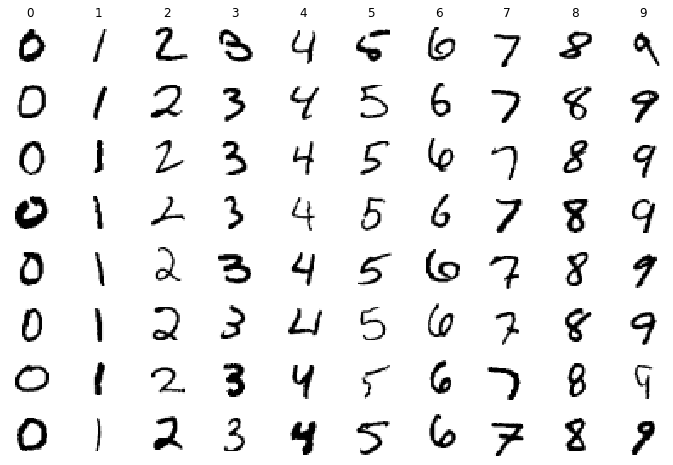

In [132]:
images, labels = zip(*list(datasets.MNIST('../data', train=False)))

rows = 8
for j in range(10):
    digits = [i for i, d in enumerate(labels) if d == j]
    for i in range(rows):
        plt.subplot(rows, 10, 10*i + j + 1)
        plt.imshow(images[digits[i]], cmap="gray_r")
        plt.axis('off')
        if i == 0:
            plt.title("{}".format(j))

### Set up the network model and optimizer

In [9]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)
scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
epoch = 1

### Run single epoch of training
You can run this cell as many times as you need

In [140]:
train(args, model, device, train_loader, optimizer, epoch)
test(args, model, device, test_loader)
scheduler.step()
epoch += 1

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.012712
Train Epoch: 14 [6400/60000 (11%)]	Loss: 0.000341
Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.021011
Train Epoch: 14 [19200/60000 (32%)]	Loss: 0.000594
Train Epoch: 14 [25600/60000 (43%)]	Loss: 0.075625
Train Epoch: 14 [32000/60000 (53%)]	Loss: 0.031766
Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.001243
Train Epoch: 14 [44800/60000 (75%)]	Loss: 0.009294
Train Epoch: 14 [51200/60000 (85%)]	Loss: 0.003091
Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.007069

Test set: Average loss: 0.0279, Accuracy: 9918/10000 (99%)



### Save the model

In [11]:
torch.save(model.state_dict(), "mnist_cnn.pt")

### Show model mistakes

In [119]:
def get_test_result(args, model, device, test_loader):
    model.eval()
    with torch.no_grad():
        result = []
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            result.append(pred.cpu().detach().numpy().reshape(-1))
    return np.concatenate(result)

result = get_test_result(args, model, device, test_loader)

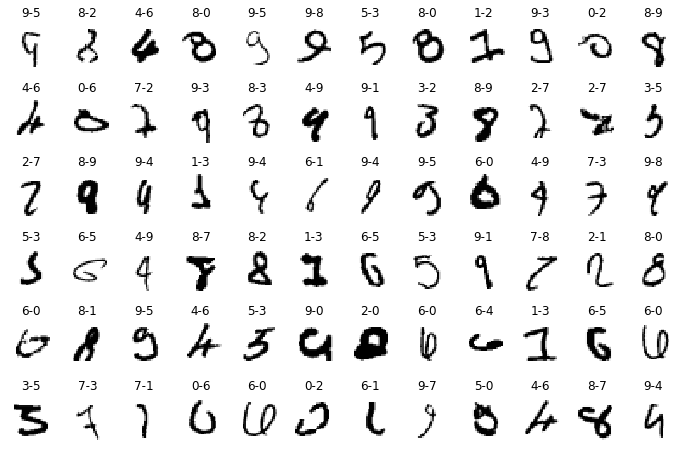

In [141]:
rows, cols = 6, 12
idx = 0
for j in range(cols):
    for i in range(rows):
        while idx < len(result) and labels[idx] == result[idx]:
            idx += 1
        if idx >= len(result):
            break
        plt.subplot(rows, cols, cols*i + j + 1)
        plt.imshow(images[idx], cmap="gray_r")
        plt.axis('off')
        plt.title("{}-{}".format(labels[idx], result[idx]))
        idx += 1